<a href="https://colab.research.google.com/github/alracey/level4-project/blob/main/1D_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapezoid


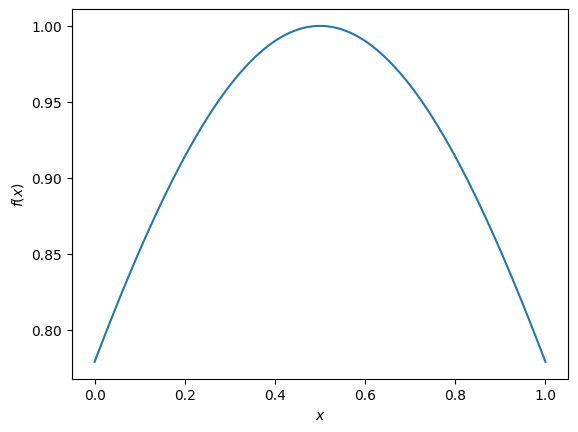

In [7]:
def f(x):
  return np.exp(-(x-0.5)**2)

xs = np.linspace(0, 1, 100)
f_evals = f(xs)
plt.plot(xs, f_evals)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

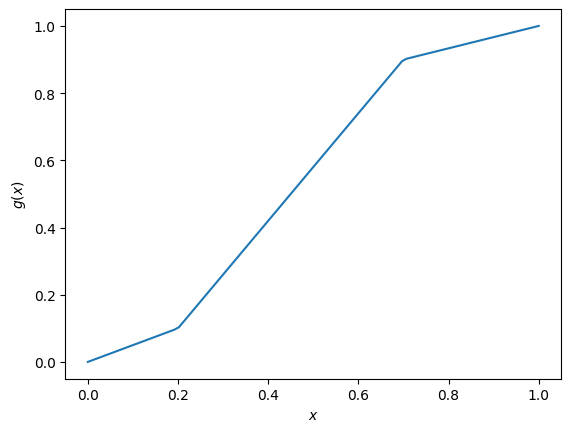

In [23]:
####initial guesses for x1,x2,y1,y2####
params = [0.2, 0.1, 0.7, 0.9]
x_1, y_1, x_2, y_2 = params[0], params[1], params[2], params[3]

#define piecewise function
def g(x, params):
    x1, y1, x2, y2 = params[0], params[1], params[2], params[3]

    g1 = lambda x: x * y1 / x1
    g2 = lambda x: y1 + ((y2 - y1) / (x2 - x1)) * (x - x1)
    g3 = lambda x: y2 + ((1 - y2) / (1 - x2)) * (x - x2)

    return np.piecewise(
        x,
        [x < x1, (x >= x1) & (x < x2), x >= x2],
        [g1, g2, g3]
    )

plt.plot(xs, g(xs, params))
plt.xlabel('$x$')
plt.ylabel('$g(x)$')
plt.show()

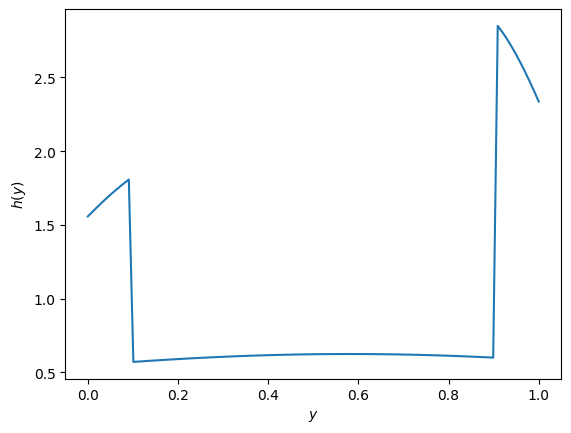

In [24]:
#define the transformed function

def transformed_f(y, params):
  x1, y1, x2, y2 = params[0], params[1], params[2], params[3]

  #inverse of g

  g1i = lambda y: (x1 / y1) * y
  g2i = lambda y: x1 + ((x2 - x1) / (y2 - y1)) * (y - y1)
  g3i = lambda y: x2 + ((1 - x2) / (1 - y2)) * (y - y2)

  #Jacobians

  jac1 = x1 / y1
  jac2 = (x2 - x1) / (y2 - y1)
  jac3 = (1 - x2) / (1 - y2)

  h1 = lambda y: f(g1i(y)) * jac1
  h2 = lambda y: f(g2i(y)) * jac2
  h3 = lambda y: f(g3i(y)) * jac3

  return np.piecewise(y, [y < y1, (y >= y1) & (y < y2), y >= y2], [h1, h2, h3])

ys = np.linspace(0, 1, 100)
h = transformed_f(ys, params)
plt.plot(ys, h)
plt.xlabel('$y$')
plt.ylabel('$h(y)$')
plt.show()

In [35]:
#integration - check whether integral of f and h is the same
F = trapezoid(f_evals, xs)
print("Trapezoid method: F = ", F)
F_q = quad(f, 0, 1)
print("Quad method: F_q = ", F_q[0])


dy = (ys[-1] - ys[0])/(len(ys)-1)
H_1, H_2, H_3 = trapezoid(h[h<y_1], dx=dy), trapezoid(h[(h>=y_1) & (h<y_2)], dx=dy), trapezoid(h[h>y_2], dx=dy)
H = np.sum([H_1, H_2, H_3])
print("Trapezoid method: H = ", H)
H_q = quad(transformed_f, 0, 1, args=(params))
print("Quad method: H_q = ", H_q[0])

Trapezoid method: F =  0.9225487691530857
Quad method: F_q =  0.9225620128255849
Trapezoid method: H =  0.9022796169782841
Quad method: H_q =  0.9225620128219222


In [36]:
#Calculate the variances before optimising parameters

#variance of original function
f_var = np.var(f_evals)

#variance of transformed function
h_var = np.var(h)

print("Variance of original function:", f_var)
print("Variance of transformed function:", h_var)

Variance of original function: 0.004667025123124368
Variance of transformed function: 0.426044719896896


In [38]:
#Optimisation - need to use a function which will find the values of x_1, x_2, y_1, y_2 which minimise the variance of h.

#constraints: 0 < x_1 < x_2 < 1; 0 < y_1 < y_2 < 1

def objective(x, params):
    y = g(x, params)
    return np.var(transformed_f(y, params))


     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 1.1451015227783491e-07
           x: [ 1.915e-01  1.927e-01  8.086e-01  8.073e-01]
         nit: 7
         jac: [-8.667e-05  9.540e-05  1.047e-04 -9.540e-05]
        nfev: 35
        njev: 7
 multipliers: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]


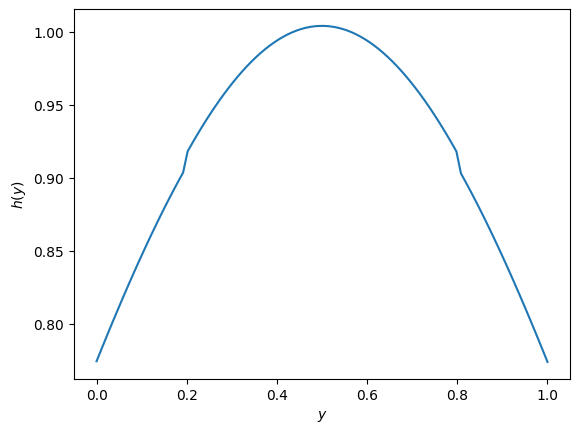

In [44]:
#optimise
from scipy.optimize import minimize
x0 = np.array([0.2, 0.1, 0.7, 0.9])
epsilon = 1e-4
bounds = [(epsilon, 1- epsilon),
          (epsilon, 1- epsilon),
          (epsilon, 1- epsilon),
          (epsilon, 1- epsilon)
          ]

constraints = [
    {'type': 'ineq', 'fun': lambda p: p[3] - p[1]},     # y2 > y1
    {'type': 'ineq', 'fun': lambda p: p[2] - p[0]},     # x2 > x1
    {'type': 'ineq', 'fun': lambda p: 1 - p[2]},        # x2 < 1
    {'type': 'ineq', 'fun': lambda p: 1 - p[3]},        # y2 < 1
]

x = np.linspace(0, 1, 100)
result = minimize(
    objective,
    x0,
    args=(x),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

print(result)
#print("Optimized parameters:", result.x)
#print("Final variance:", result.fun)

transformed_evals = transformed_f(ys, result.x)
plt.plot(ys, transformed_evals)
plt.xlabel('$y$')
plt.ylabel('$h(y)$')
plt.show()